In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

import sys
sys.path.append('..')
from pvpro import PvProHandler
from solardatatools import DataHandler

In [3]:
from datetime import datetime

In [4]:
def load_constellation_data(file_id, location='s3://pv.insight.misc/pv_fleets/',
                            data_fn_pattern='{}_20201006_composite.csv',
                            index_col=0, parse_dates=[0], json_file=False):
    df = pd.read_csv(location + data_fn_pattern.format(file_id), index_col=index_col, parse_dates=parse_dates)

    if json_file:
        try:
            from smart_open import smart_open
        except ImportError:
            print('Please install smart_open in your Python environment to use this function')
            return
        for line in smart_open(location + str(file_id) + '_system_details.json', 'rb'):
            file_json = json.loads(line)
            file_json
        return df, file_json
    return df

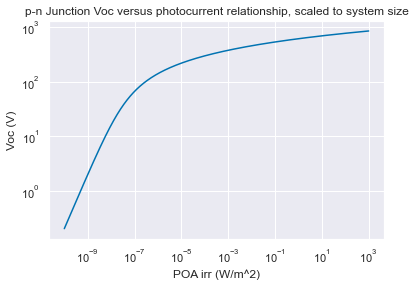

In [5]:
# Estimate of cells in series
Ns = 800/0.6
# Constants
E0=1000
q = 1.602e-19
kB = 1.381e-23
T = 25+273.15

Il = np.logspace(-10, 3, 5000)
Vs = Ns*kB*T/q*np.log(6 * Il / 1e-10 / E0 + 1)
plt.plot(Il, Vs);
plt.xscale('log')
plt.yscale('log')
plt.xlabel('POA irr (W/m^2)')
plt.ylabel('Voc (V)')
plt.title('p-n Junction Voc versus photocurrent relationship, scaled to system size');

In [6]:
# df, js = load_constellation_data(5044, json_file=True) #5297 same as 5302 ??
# df, js = load_constellation_data(5317, json_file=True) # clipping detection failed
# df, js = load_constellation_data(5217, json_file=True)
df, js = load_constellation_data(5297, json_file=True)

In [7]:
volt_cols = [i for i in df.columns if 'dc_volt' in i]
pow_cols = [i for i in df.columns if 'dc_pow' in i]
curr_cols = [i for i in df.columns if 'dc_cur' in i]
irr_cols = [i for i in df.columns if 'poa' in i]
modT_cols = [i for i in df.columns if 'temperature_module' in i]

if len(pow_cols) == 0 & (len(volt_cols) != 0 & len(curr_cols) != 0):
    pow_cols = ['dc_power_inv_{}'.format(key.split('_')[-1]) for key in volt_cols]
    for ix, pc in enumerate(pow_cols):
        df[pc] = df[volt_cols[ix]] * df[curr_cols[ix]]


In [8]:
dh = DataHandler(df)

In [9]:
sys_ix = 0
dh.fix_dst()
dh.run_pipeline(power_col=pow_cols[sys_ix], extra_cols=[volt_cols[sys_ix]], fix_shifts=False)

total time: 5.70 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              3.71s
Cleaning                   0.19s
Filtering/Summarizing      1.80s
    Data quality           0.27s
    Clear day detect       0.22s
    Clipping detect        0.26s
    Capacity change detect 1.04s
Extra Column Processing    0.00s


In [10]:
dh.report()

Length:                3.37 years
Capacity estimate:     0.64 kW
Data sampling:         15 minute
Data quality score:    96.2%
Data clearness score:  17.9%
Inverter clipping:     True
Time shifts corrected: None
Time zone correction:  None


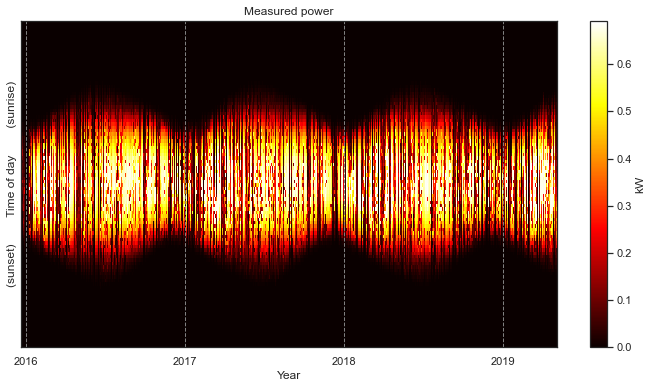

In [11]:
dh.plot_heatmap('filled');

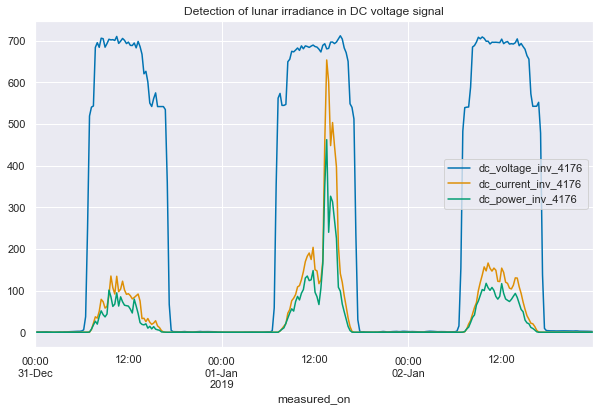

<Figure size 432x288 with 0 Axes>

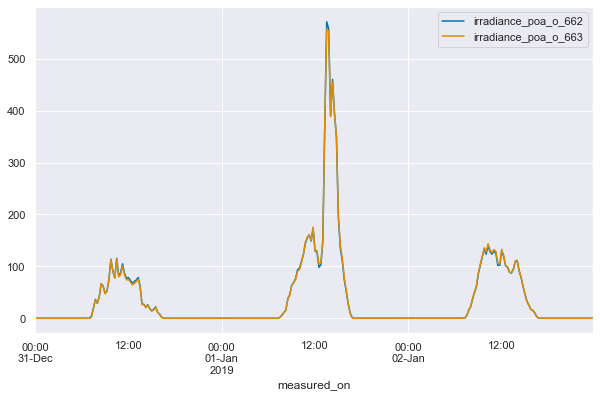

In [12]:
start = '2018-12-31'
end = '2019-01-02'
sys_ix = 0
df[[volt_cols[sys_ix], curr_cols[sys_ix], pow_cols[sys_ix]]].loc[start:end].plot(figsize=(10, 6))
# plt.axhline(0.05 * np.nanquantile(df['dc_voltage_inv_4176'], 0.98), color='red', ls='--')
# plt.axvline(datetime(2016, 1, 21, 15, 15), color='red', ls='--', label='moonrise')
# plt.axvline(datetime(2016, 1, 22, 5, 52), color='green', ls='--', label='moonset')
# plt.axvline(datetime(2016, 1, 21, 22, 30), color='orange', ls='--', label='lunar noon')
plt.legend()
plt.title('Detection of lunar irradiance in DC voltage signal');
plt.figure()
df[irr_cols].loc[start:end].plot(figsize=(10, 6))
plt.legend();

In [13]:
np.nanstd(dh.extra_matrices[volt_cols[sys_ix]][0])

14.561736354191003

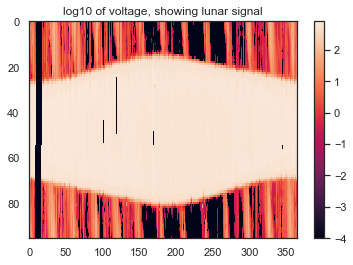

In [14]:
query = dh.extra_matrices[volt_cols[sys_ix]][:, :365]
data = -4 * np.ones_like(query)
msk = query > 0
data[msk] = np.log10(query[msk])
with sns.axes_style('white'):
    plt.imshow(data, aspect='auto', interpolation='none')
    plt.colorbar()
    plt.title('log10 of voltage, showing lunar signal');

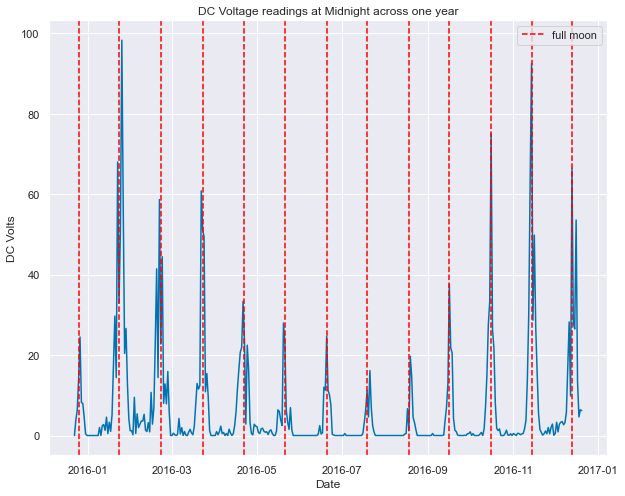

In [15]:
### AZ
# fm = [datetime(2016, 10, 15), datetime(2016, 11, 14), datetime(2016, 12, 13)]
# foo = [datetime(2017, i, j) for i, j in [
#     (1, 12), (2, 10), (3, 12), (4, 10), (5, 10), (6, 9), (7, 8), (8, 7),
#     (9, 6)
# ]]
# fm.extend(foo)
## Maryland
foo = [datetime(2016, i, j) for i, j in [
    (1, 23), (2, 22), (3, 23), (4, 22), (5, 21), (6, 20), (7, 19), (8, 18),
    (9, 16), (10, 16), (11, 14), (12, 13)
]]
fm = [datetime(2015, 12, 25)]
fm.extend(foo)
plt.figure(figsize=(10, 8))
slct = np.logical_and(
    dh.day_index > datetime(2015, 12, 15),
    dh.day_index < datetime(2017, 1, 1)
)
plt.plot(dh.day_index[:365], 10 ** data[0])
first = True
for v in fm:
    if first:
        plt.axvline(v, color='red', ls='--', linewidth=1.5, label='full moon')
        first = False
    else:
        plt.axvline(v, color='red', ls='--', linewidth=1.5)
plt.legend()
plt.title('DC Voltage readings at Midnight across one year')
plt.ylabel('DC Volts')
plt.xlabel('Date')
plt.show();

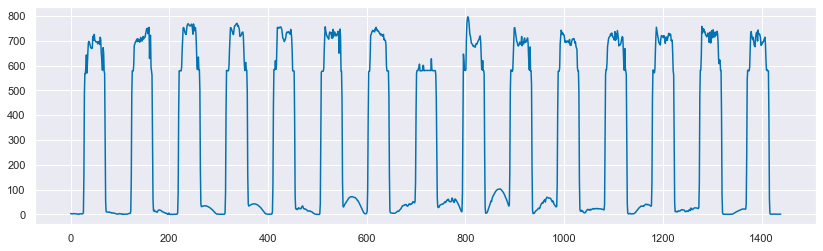

In [33]:
plt.figure(figsize=(14, 4))
plt.plot((dh.extra_matrices[volt_cols[sys_ix]][:, 25:40]).ravel(order='F'))